<a href="https://colab.research.google.com/github/kkrusere/youTube-comments-Analyzer/blob/main/YT_sentiment_exp_summarization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%%shell
sudo apt -y update
sudo apt install -y wget curl unzip
wget http://archive.ubuntu.com/ubuntu/pool/main/libu/libu2f-host/libu2f-udev_1.1.4-1_all.deb
dpkg -i libu2f-udev_1.1.4-1_all.deb
wget https://dl.google.com/linux/direct/google-chrome-stable_current_amd64.deb
dpkg -i google-chrome-stable_current_amd64.deb

wget -N https://edgedl.me.gvt1.com/edgedl/chrome/chrome-for-testing/118.0.5993.70/linux64/chromedriver-linux64.zip -P /tmp/
unzip -o /tmp/chromedriver-linux64.zip -d /tmp/
chmod +x /tmp/chromedriver-linux64/chromedriver
mv /tmp/chromedriver-linux64/chromedriver /usr/local/bin/chromedriver
pip install selenium chromedriver_autoinstaller

pip install bitsandbytes
pip install accelerate
pip install trl peft
pip install datasets
pip install rouge-score
pip install evaluate
pip install huggingface_hub
pip install transformers

In [18]:
from google.colab import drive, userdata
from huggingface_hub import login

import os
import json
#mounting google drive
drive.mount('/content/drive')

########################################

#changing the working directory
os.chdir("/content/drive/MyDrive/NLP_Data")

!pwd

huggingface_token = userdata.get('Hugging_Face_Hub_API_TOKEN')

#logging into huggingface
login(huggingface_token)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/NLP_Data
The token has not been saved to the git credentials helper. Pass `add_to_git_credential=True` in this function directly or `--add-to-git-credential` if using via `huggingface-cli` if you want to set the git credential as well.
Token is valid (permission: read).
Your token has been saved to /root/.cache/huggingface/token
Login successful


In [19]:
import sys
sys.path.insert(0,'/usr/lib/chromium-browser/chromedriver')


from selenium import webdriver
import chromedriver_autoinstaller
from selenium.webdriver.common.by import By
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.common.action_chains import ActionChains
from selenium.webdriver.chrome.service import Service
from selenium.common.exceptions import TimeoutException, ElementNotInteractableException
from selenium.webdriver.common.action_chains import ActionChains

from bs4 import BeautifulSoup
import requests

import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore")

import time
import re
import random

import operator
from google.colab import userdata
api_key = userdata.get('YouTubeAPI_key')

import googleapiclient.discovery
from googleapiclient.discovery import build

from datasets import Dataset

from sklearn.model_selection import train_test_split
from datasets import Dataset
from transformers import BartTokenizer, BartForConditionalGeneration, TrainingArguments, Trainer
from peft import LoraConfig, get_peft_model

import torch
import evaluate
from evaluate import load
from rouge_score import rouge_scorer, scoring

In [20]:
# Below are functions for reading a writting json file for the current working directory

def save_to_json(data, filename):
    with open(filename, 'w') as json_file:
        json.dump(data, json_file, indent=4)

def load_from_json(filename):
    with open(filename, 'r') as json_file:
        comments = json.load(json_file)
    return comments

In [21]:
# Function to convert string values containing suffixes 'K', 'M', or 'B' to integers and extract numeric values.
def convert_to_int(value):
  """
    - If the value is NaN or an empty string, return 0.
    - If the value is a string:
      - Extract numeric digits from the string.
      - Convert the extracted digits to an integer.
      - If the string contains 'K', multiply the number by 1,000.
      - If the string contains 'M', multiply the number by 1,000,000.
      - If the string contains 'B', multiply the number by 1,000,000,000.
    - Return the converted integer value.

  """
  if pd.isna(value) or value == '':
      return 0
  if isinstance(value, str):
      # Extract numbers and convert them
      num = re.findall(r'\d+', value)
      if not num:
          return 0
      num = ''.join(num)
      if 'K' in value:
          return int(float(num) * 1000)
      if 'M' in value:
          return int(float(num) * 1000000)
      if 'B' in value:
          return int(float(num) * 1000000000)
      return int(num)
  return int(value)

In [22]:
# Initialize YouTube API client
def initialize_youtube_api(api_key):
    return build("youtube", "v3", developerKey=api_key)

def init_webdriver():
    """Initializes and returns a Chrome WebDriver instance with options."""
    try:
        chrome_options = webdriver.ChromeOptions()
        chrome_options.add_argument('--headless')
        chrome_options.add_argument('--no-sandbox')
        chrome_options.add_argument('--disable-dev-shm-usage')
        chromedriver_autoinstaller.install()
        driver = webdriver.Chrome(options=chrome_options)

        print("WebDriver initialized successfully")  # Confirm initialization
        return driver
    except Exception as e:
        print(f"Failed to initialize WebDriver: {e}")
        raise

def close_webdriver(driver):
    """Closes the provided WebDriver instance."""
    print("WebDriver successfully closed")
    driver.quit()


In [23]:
def get_youtube_url(video_id):
  """
  Constructs a YouTube URL from a given video ID.

  Args:
      video_id: The unique identifier for a YouTube video.

  Returns:
      The full URL of the YouTube video.
  """

  video_url = f"https://www.youtube.com/watch?v={video_id}"

  return video_url


def get_video_id_from_url(url):
  """
  Extracts the video ID from a YouTube video URL.

  Args:
      url: The URL of the YouTube video.

  Returns:
      The video ID as a string, or None if the URL is invalid.
  """
  try:
    video_id = url.split("v=")[1]
    ampersand_position = video_id.find("&")
    if ampersand_position != -1:
      video_id = video_id[:ampersand_position]
    return video_id
  except IndexError:
    return None


In [24]:
def get_comments_html(video_url, driver):
    """
    Fetches the HTML content of the comments section from a YouTube video.

    This function initializes a WebDriver instance to open the provided YouTube video URL,
    scrolls down to load the comments section, and retrieves the HTML content of the loaded
    comments section.

    Args:
        video_url (str): The URL of the YouTube video from which to fetch comments.
        driver: An initialized WebDriver instance (from Selenium).

    Returns:
        str: The HTML content of the comments section.

    Raises:
        TimeoutException: If the comments section does not load within the specified time.
    """

    # Wait until the comments section is loaded
    WebDriverWait(driver, 10).until(EC.presence_of_element_located((By.CSS_SELECTOR, 'ytd-comments')))

    # Scroll to the comments section to load initial comments
    driver.execute_script("window.scrollTo(0, document.documentElement.scrollHeight);")

    # Set initial values for dynamic loading
    last_height = driver.execute_script("return document.documentElement.scrollHeight")
    scroll_pause_time = 2  # Time to wait between scrolls
    max_scrolls = 100  # Increase the max number of scrolls to ensure all comments are loaded
    scroll_count = 0

    while scroll_count < max_scrolls:
        # Scroll down to the bottom
        driver.execute_script("window.scrollTo(0, document.documentElement.scrollHeight);")

        # Wait for new comments to load dynamically
        time.sleep(scroll_pause_time)  # Simple wait to allow comments to load

        # Check the new scroll height and compare it with the last height
        new_height = driver.execute_script("return document.documentElement.scrollHeight")
        if new_height == last_height:
            # If the height hasn't changed, try one more scroll to ensure all comments are loaded
            time.sleep(scroll_pause_time)
            new_height = driver.execute_script("return document.documentElement.scrollHeight")
            if new_height == last_height:
                # If the height still hasn't changed, we've reached the end
                print("All comments have been loaded.")
                break

        last_height = new_height
        scroll_count += 1

    # Get the HTML of the comments section
    comments_html = driver.page_source

    # Close the driver
    driver.quit()

    return comments_html


def get_comment_thread_renderers(comments_html):
    """
    Parses the provided HTML content to extract YouTube comment threads and their counts.

    This function uses BeautifulSoup to parse the HTML content of a YouTube video's comments section.
    It finds and prints the number of comments and the number of comment thread renderers (`ytd-comment-thread-renderer`).
    It then returns a list of all the `ytd-comment-thread-renderer` elements found in the HTML.

    Args:
        comments_html (str): The HTML content of the comments section of a YouTube video.

    Returns:
        list: A list of `ytd-comment-thread-renderer` elements found in the HTML.
    """

    soup = BeautifulSoup(comments_html, 'html.parser')

    # Find the span element with the specified class
    comment_count_span = soup.find('span', class_='style-scope yt-formatted-string')

    # Extract the text content of the span element
    comment_count = comment_count_span.text.strip()

    # # Print or use the comment count
    # print("Comment Count:", comment_count)

    # Find all occurrences of the ytd-comment-thread-renderer element
    comment_thread_renderers = soup.find_all('ytd-comment-thread-renderer', class_='style-scope ytd-item-section-renderer')

    # Count the number of occurrences
    comment_thread_count = len(comment_thread_renderers)

    # # Print or use the comment thread count
    # print("Number of ytd-comment-thread-renderer elements:", comment_thread_count)

    return comment_thread_renderers

def get_comments(comment_thread_renderers):
    comments = list()
    comments_data = list()
    # Iterate through each comment thread renderer
    for comment_thread_renderer in comment_thread_renderers:

        # Extracting the comment text
        comment_text_element = comment_thread_renderer.find('yt-attributed-string', id='content-text')
        comment_text = comment_text_element.get_text(strip=True) if comment_text_element else None

        # Extracting the number of likes
        like_count_element = comment_thread_renderer.find('span', class_='style-scope ytd-comment-engagement-bar')
        like_count = like_count_element.get_text(strip=True) if like_count_element else None

        # Extracting the number of replies
        reply_count_element = comment_thread_renderer.find('ytd-button-renderer', id='more-replies')
        reply_count = reply_count_element.get_text(strip=True) if reply_count_element else None

        comments.append(comment_text)

        comments_data.append(
            {
            "comment_text": comment_text,
            "like_count": like_count,
            "reply_count": reply_count

            }
        )

    return comments, comments_data



def clean_description(description_data, model_path="./Desc-Sum-fine-tuned-lora-model"):
    """
    Cleans and summarizes YouTube video descriptions using a fine-tuned LoRA model.

    Args:
        description_data: A list of dictionaries containing video details (channel_name, video_title, video_description).
        model_path: The path to the fine-tuned LoRA model.

    Returns:
        A list of cleaned and summarized video descriptions.
    """
    # Configure LoRA
    lora_config = LoraConfig(
        r=16,  # Rank of the LoRA matrix
        lora_alpha=32,  # Scaling factor for LoRA
        target_modules=["q_proj", "v_proj"],  # Target attention layers to apply LoRA
        lora_dropout=0.05,  # Dropout rate for LoRA
        bias="none",  # No bias
    )

    # Preparing input for inference
    formatted_inputs = [
        f"Channel: {item['channel_name']}, Title: {item['video_title']}, Description: {item['video_description']}"
        for item in description_data
    ]


    # Loading the fine-tuned LoRA model and tokenizer
    model = BartForConditionalGeneration.from_pretrained(model_path)

    # # Tokenize input
    tokenizer = BartTokenizer.from_pretrained(model_path)
    inputs = tokenizer(formatted_inputs, max_length=512, return_tensors="pt", truncation=True, padding="max_length")

    # Move inputs to the same device as the model
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    inputs = {key: value.to(device) for key, value in inputs.items()}


    # LoRA configuration applied to the model
    lora_model = get_peft_model(model, lora_config)
    lora_model.to(device)

    # Generate Cleaned Descriptions
    with torch.no_grad():
        outputs = lora_model.generate(
            input_ids=inputs["input_ids"],
            attention_mask=inputs["attention_mask"],
            max_length=128,
            num_beams=4,
            early_stopping=True
        )

    # Decode and print summaries
    cleaned_descriptions = tokenizer.batch_decode(outputs, skip_special_tokens=True)

    return cleaned_descriptions[0]


def get_video_comments(video_url, driver):
    """
    Retrieves comments from the provided YouTube video URL.

    Args:
        video_url (str): The URL of the YouTube video.

    Returns:
        list: A list of comments and their data.
    """
    #print("\nwe are now in the get_video_comments function\n")
    comments_html = get_comments_html(video_url, driver)  # Get HTML of comments section
    comment_thread_renderers = get_comment_thread_renderers(comments_html)  # Extract comment renderers
    _, comments_data = get_comments(comment_thread_renderers)  # Extract comment data

    return comments_data


def get_video_data(video_id):
    """Fetches video data from YouTube given a video ID.

    Args:
        video_id (str): The ID of the YouTube video to fetch data for.

    Returns:
        dict: A dictionary containing the video data with the following keys:
            - 'channel_name': The name of the channel that uploaded the video.
            - 'video_title': The title of the video.
            - 'video_description': The description of the video.

    Raises:
        Exception: If there is an error accessing or processing the video data.
    """
    driver = init_webdriver()
    video_url = f"https://www.youtube.com/watch?v={video_id}"
    video_data = {}

    try:
        driver.get(video_url)

        # Handle YouTube consent dialog if it appears
        try:
            consent_button = WebDriverWait(driver, 10).until(
                EC.element_to_be_clickable((By.XPATH, '//button[contains(., "I agree")]'))
            )
            consent_button.click()
        except TimeoutException:
            print("No consent dialog found or already handled.")

        # Handle any other potential modal dialogs that might pop up
        try:
            dialog_close_button = WebDriverWait(driver, 5).until(
                EC.element_to_be_clickable((By.XPATH, '//button[@aria-label="Close"]'))
            )
            dialog_close_button.click()
        except TimeoutException:
            print("No additional modal dialogs found.")

        try:
            # Wait for the bottom-row element to be present
            bottom_row = WebDriverWait(driver, 20).until(
                EC.presence_of_element_located((By.XPATH, '//*[@id="bottom-row"]'))
            )

            # Locate and click the expand button if it exists
            try:
                expand_button = WebDriverWait(driver, 10).until(
                    EC.presence_of_element_located((By.XPATH, '//tp-yt-paper-button[@id="expand"]'))
                )

                # Use JavaScript to click the element to bypass any overlay issues
                driver.execute_script("arguments[0].scrollIntoView();", expand_button)
                driver.execute_script("arguments[0].click();", expand_button)
            except TimeoutException:
                pass  # Ignore if the expand button is not found

            # Wait for elements to be visible and extract data
            expanded_description = WebDriverWait(driver, 10).until(
                EC.visibility_of_element_located((By.ID, 'description-inline-expander'))
            )
            title_element = WebDriverWait(driver, 10).until(
                EC.presence_of_element_located((By.XPATH, '//h1[@class="style-scope ytd-watch-metadata"]//yt-formatted-string'))
            )
            channel_name_element = WebDriverWait(driver, 10).until(
                EC.presence_of_element_located((By.XPATH, '//ytd-channel-name[@id="channel-name"]//yt-formatted-string//a'))
            )

            video_data = {
                'channel_name': channel_name_element.text,
                'video_title': title_element.text,
                'video_description': expanded_description.text
            }

            # Clean the description
            temp_list = [video_data]
            cleaned_description = clean_description(temp_list)
            video_data['video_description'] = cleaned_description

            # Fetch comments
            comments_data = get_video_comments(video_url, driver)
            video_data['comments'] = comments_data

        except TimeoutException:
            print(f"Error processing {video_url}: Elements not found within timeout.")

    except Exception as e:
        print(f"Error processing {video_url}: {e}")

    finally:
        # Close the browser when done
        close_webdriver(driver)

    return video_data


In [25]:
def convert_video_comments_to_dataframe(video_data):
    """
    Converts the video data and its comments into a pandas DataFrame and dictionary format.

    Args:
        video_data (dict): Dictionary containing the video details and its comments.

    Returns:
        dict: A list of dictionaries, each representing a comment with video details.
    """
    rows = []

    # Iterate through the comments and create a row for each
    for comment in video_data['comments']:
        row = {
            'channel_name': video_data['channel_name'],
            'video_title': video_data['video_title'],
            'video_description': video_data['video_description'],
            'comment_text': comment['comment_text'],
            'like_count': comment['like_count'],
            'reply_count': comment['reply_count']
        }
        rows.append(row)

    # Convert rows to a DataFrame
    df = pd.DataFrame(rows)

    # Convert 'like_count' and 'reply_count' to integers using 'convert_to_int' function
    df['like_count'] = df['like_count'].apply(convert_to_int)
    df['reply_count'] = df['reply_count'].apply(convert_to_int)

    # Convert DataFrame back to dictionary format
    data_dict = df.to_dict(orient='records')

    return data_dict


In [26]:
video_id = "S-FDNSKZOgA"  #@param {type:"string"}
video_data = get_video_data(video_id)


WebDriver initialized successfully
No consent dialog found or already handled.
No additional modal dialogs found.
All comments have been loaded.


WebDriver successfully closed


In [27]:
data_dict = convert_video_comments_to_dataframe(video_data)

In [28]:
def prepare_test_data_from_dict(data_dict):
    """
    Prepares the test data for inference by formatting the input data from a list of dictionaries.

    Args:
        data_dict (list of dict): A list of dictionaries containing video details and comments.

    Returns:
        Dataset: A Hugging Face Dataset with formatted input data.
    """
    # Convert the input data into a DataFrame
    df = pd.DataFrame(data_dict)

    # Format the input data
    formatted_input_data = [
        {
            "input": f"Channel: {row['channel_name']}, Title: {row['video_title']}, Description: {row['video_description']}, Comment Text: {row['comment_text']}",
            "output": ""  # Output is empty for test data
        }
        for _, row in df.iterrows()
    ]

    # Convert the formatted data into a Dataset
    return Dataset.from_list(formatted_input_data)

def tokenize_dataset(dataset, tokenizer):
    """
    Tokenizes the dataset for model inference.

    Args:
        dataset (Dataset): A Hugging Face Dataset containing the input data.
        tokenizer (PreTrainedTokenizer): A tokenizer for encoding the input data.

    Returns:
        Dataset: A tokenized dataset ready for model inference.
    """
    # Tokenization function
    def tokenize_data(example):
        model_inputs = tokenizer(
            example["input"],
            max_length=512,
            padding="max_length",
            truncation=True
        )
        return model_inputs

    # Apply tokenization to the dataset
    return dataset.map(tokenize_data, batched=True)

def run_inference(model, tokenizer, tokenized_dataset):
    """
    Runs inference on the tokenized dataset using the provided model and tokenizer.

    Args:
        model (PreTrainedModel): A pre-trained model for generating predictions.
        tokenizer (PreTrainedTokenizer): A tokenizer for encoding and decoding inputs/outputs.
        tokenized_dataset (Dataset): The tokenized dataset on which to perform inference.

    Returns:
        list: A list of predictions generated by the model.
    """
    model.eval()  # Set the model to evaluation mode
    predictions = []

    for example in tokenized_dataset:
        # Prepare inputs for the model
        inputs = tokenizer(example['input'], return_tensors='pt', truncation=True, padding=True, max_length=512)

        # Generate outputs (predictions)
        outputs = model.generate(**inputs)

        # Decode the predictions
        prediction = tokenizer.decode(outputs[0], skip_special_tokens=True)
        predictions.append(prediction)

    return predictions

def get_predictions_from_data_dict(data_dict, model, tokenizer):
    """
    Processes the data from `data_dict`, runs inference, and returns predictions.

    Args:
        data_dict (list of dict): A list of dictionaries containing video data and comments.
        model (PreTrainedModel): A pre-trained model for generating predictions.
        tokenizer (PreTrainedTokenizer): A tokenizer for encoding and decoding inputs/outputs.

    Returns:
        list: A list of predictions for each entry in the data_dict.
    """
    # Prepare and format the input data
    formatted_dataset = prepare_test_data_from_dict(data_dict)

    # Tokenize the dataset
    tokenized_dataset = tokenize_dataset(formatted_dataset, tokenizer)

    # Run inference to get predictions
    predictions = run_inference(model, tokenizer, tokenized_dataset)

    return predictions


In [29]:
model = BartForConditionalGeneration.from_pretrained("./SA-bart-fine-tuned-lora-model")
tokenizer = BartTokenizer.from_pretrained("./SA-bart-fine-tuned-lora-model")

In [30]:
predictions = get_predictions_from_data_dict(data_dict, model, tokenizer)

Map:   0%|          | 0/36 [00:00<?, ? examples/s]

In [31]:
def split_sentiment_explanation(item):
    sentiment_part, explanation_part = item.split(", Explanation: ")
    sentiment = sentiment_part.replace("Sentiment: ", "").strip()
    explanation = explanation_part.strip()
    return sentiment, explanation

# Split the data into two lists: Sentiment and Explanation
sentiments, explanations = zip(*[split_sentiment_explanation(item) for item in predictions])

# Create DataFrame
df = pd.DataFrame({
    'Sentiment': sentiments,
    'Explanation': explanations
})



In [32]:
df.head()

,Sentiment,Explanation
0,Negative/Concerned,The comment expresses concern about the safety...
1,Negative/Critical,The comment criticizes the treatment of Eric T...
2,Neutral/Observational,The comment expresses a positive view of the s...
3,Neutral/Inquisitive,The comment asks the question 'Did… did they j...
4,Neutral/Observational,The comment suggests that Eric Trump should be...


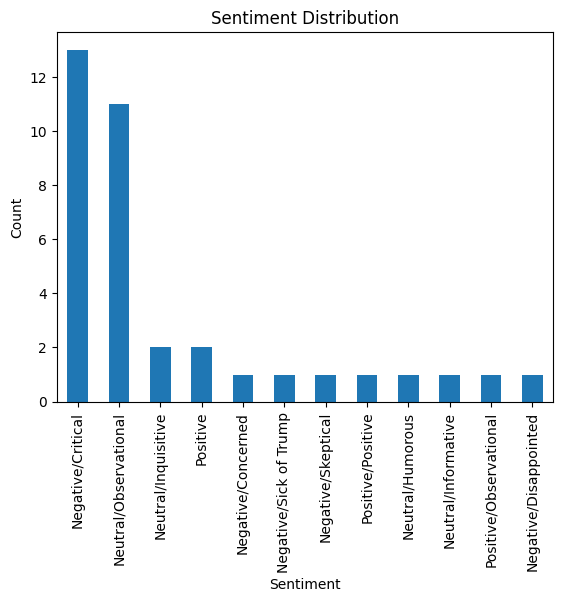

In [33]:
import matplotlib.pyplot as plt

# Plot the value counts of the "Sentiment" column
df["Sentiment"].value_counts().plot(kind='bar')

# Add labels and title
plt.xlabel("Sentiment")
plt.ylabel("Count")
plt.title("Sentiment Distribution")

# Show the plot
plt.show()


In [34]:
predictions

["Sentiment: Negative/Concerned, Explanation: The comment expresses concern about the safety of Eric Trump's father's golf game, asking if he can play safely after a second assassination attempt. It expresses concern that it's only a matter of time before a third assassination attempt occurs.",
 "Sentiment: Negative/Critical, Explanation: The comment criticizes the treatment of Eric Trump after his father's second attempt on his life, implying that he is treated like a hero after being almost assassinated twice and deserves more protection. The comment expresses a negative view of the security surrounding Trump's favorite pastime golf, calling it a security nightmare.",
 "Sentiment: Neutral/Observational, Explanation: The comment expresses a positive view of the security surrounding Trump's favorite pastime golf, suggesting a positive outlook on the situation. It doesn't express a negative or negative sentiment toward the current situation, simply expresses hope that things will improv